# Example: Human segmentation with attention U-net and transfer learning from ImageNet-trained VGG16 model

In [7]:
from glob import glob

import numpy as np
from keras_unet_collection import models, utils
from tensorflow import keras

In [14]:


train_path = 'C:\\Users\\AEVO\\Desktop\\subset\\train\\'
val_path = 'C:\\Users\\AEVO\\Desktop\\subset\\val\\'

In [15]:
# file path after data extraction
path_train_img = train_path
path_train_mask = train_path

path_test_img = val_path
path_test_mask = val_path

### Subsetting human samples

For obtaining a better focus of the segmentation target, human samples are subsetted from COCO.

The selection criteria is that after resizing to 128-by-128, human samples should have more than 33% of its 64-by-64 central pixels belong to the human/person category.

As a binary segmentation problem, non-human COCO-stuff labels are grouped and labelled as "background". Accessory categories (e.g., ties) are also grouped into the background.

**Note**: sample subsetting code cells are time-consuming.

In [7]:
def split_human_samples(label_filenames, human_id=0, human_rate=1 / 3):
    '''
    Subsetting samples that contain "person/human" category from the COCO dataset
    ----------
    human_id = 0 : COCO stuffthingmaps label human as int 0
    human_rate = 1/3: at least 33% of the pixels should belong to human.
    ----------
    '''
    thres = int(64 * 64 * human_rate)  # pixel number thres after resizing
    L = len(label_filenames)
    flag = []  # return a list of booleans

    for i in range(L):
        sample_ = utils.image_to_array([label_filenames[i]], size=128, channel=1)
        if np.sum(sample_[0, 32:-32, 32:-32, 0] == human_id) > thres:
            flag.append(True)
        else:
            flag.append(False)

    return flag

In [16]:
path_train_img

'C:\\Users\\AEVO\\Desktop\\subset\\train\\'

In [17]:
trainval_input_names = np.array(sorted(glob(path_train_img + '*.jpg')))
trainval_label_names = np.array(sorted(glob(path_train_img + '*.png')))

In [18]:
test_input_names = np.array(sorted(glob(path_test_img + '*.jpg')))
test_label_names = np.array(sorted(glob(path_test_mask + '*.png')))

### Training-validation data split

The COCO validation samples are treated as testing sets.

The validation data of this example is split form the COCO training samples.

In [19]:
len(trainval_input_names)

621

In [22]:
L = len(trainval_input_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.9 * L);
L_valid = L - L_train
ind_train = ind_all[:L_train];
ind_valid = ind_all[L_train:]

train_input_names = trainval_input_names[ind_train]
train_label_names = trainval_label_names[ind_train]
valid_input_names = trainval_input_names[ind_valid]
valid_label_names = trainval_label_names[ind_valid]

print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, len(test_label_names)))

Training:validation:testing = 558:63:400


('C:\\Users\\AEVO\\Desktop\\subset\\train\\121.jpg',
 'C:\\Users\\AEVO\\Desktop\\subset\\train\\121.png')

### Exploratory data analysis

In [24]:
import matplotlib.pyplot as plt


def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=False, left=False, right=False,
                   labelleft=False)
    return ax

In [25]:
i_max = 10  # explore 10 images
input_example = utils.image_to_array(train_input_names[:i_max], size=128, channel=3)
label_example = utils.image_to_array(train_label_names[:i_max], size=128, channel=1)

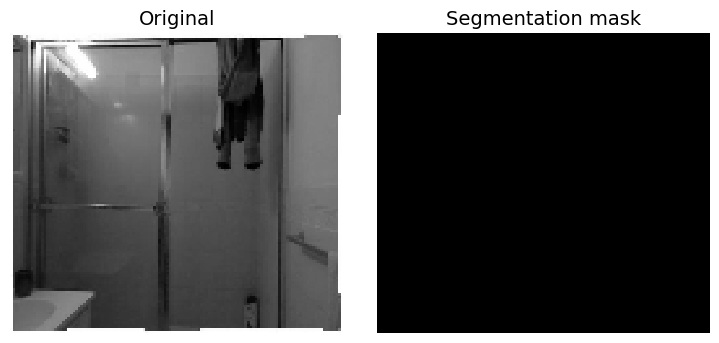

In [28]:
i_example = 2

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)

AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(label_example[i_example, ..., 0] > 0, cmap=plt.cm.gray)
AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Segmentation mask", fontsize=14);

## Attention U-net with an ImageNet-trained backbone

Attention U-net is applied for this segmentation task. This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level. 

Attention gates take upsampled (i.e., decoded) and downsampled (i.e., encoded) tensors as queries and keys, respectively. These queries and keys are mapped to intermediate channel sizes and fed into the additive attention learning. The resulting vector is rescaled by a sigmoid function and multiplied with the downsampled tensor (keys, but here treated as "values" of self-attention). The attention gate output replaces the downsampled tensor and is concatenated with the upsampled tensor.

Based on the amount and complexity of COCO samples, ImageNet-trained VGG16 is applied as an encoder backbone. This transfer learning strategy is expected to improve the segmentation performance based on two reasons: 

 * The ImageNet and COCO containts (somewhat) similar kinds of natural images with a high overlap of data distribution; 

 * The VGG16 architecture is a combination of same-padding convolution and max-pooling kernels, capable of extracting hierarchical features that can be processed by attention gates (ResNet backbone contains zero padding layers and is suboptimal in this case).

The code cell below configures the attention U-net with an ImageNet-trained VGG16 backbone. Hyper-parameters are explained through the Python helper function:

```python
from keras_unet_collection import models

help(models.att_unet_2d)
```

In [29]:
model = models.att_unet_2d(
    (128, 128, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=1,
    stack_num_down=2, stack_num_up=2, activation='ReLU',
    atten_activation='ReLU', attention='add', output_activation='Sigmoid',
    batch_norm=True, pool=False, unpool=False,
    backbone='VGG16', weights='imagenet',
    freeze_backbone=True, freeze_batch_norm=True,
    name='attunet'
)

C:\Users\AEVO\Desktop\pessoal\IFES\dissertacao\unet_depth\venv\lib\site-packages\keras_unet_collection\_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58889256/58889256 [==============================] - 2s 0us/step


The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [30]:
model.layers[1].name

'VGG16_backbone'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [31]:
import tensorflow as tf
import tensorflow.keras.backend as K


# custom loss
def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 1.0, 0.1

    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))


#custom soft accuracy
def depth_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))(loss=keras.losses.categorical_crossentropy,
                                                             optimizer=keras.optimizers.SGD(lr=1e-2))

In [33]:
from tensorflow.keras.optimizers import Adam

INIT_LR = 0.0001
opt = Adam(learning_rate=INIT_LR, amsgrad=True)

model.compile(loss=depth_loss, metrics=[depth_acc])

In [35]:
model.summary()

Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                                   

## Training

The segmentation model is trained with 200 epoches with early stopping. Each epoch containts 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [17]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array / 255.


def target_data_process(target_array):
    '''Converting human, non-human pixels into two categories.'''
    target_array[target_array > 0] = 1  # grouping all other non-human categories
    return keras.utils.to_categorical(target_array, num_classes=2)

In [18]:
valid_input = input_data_process(utils.image_to_array(valid_input_names, size=128, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_label_names, size=128, channel=1))

In [19]:
N_epoch = 200  # number of epoches
N_batch = 100  # number of batches per epoch
N_sample = 32  # number of samples per batch

tol = 0  # current early stopping patience
max_tol = 2  # the max-allowed early stopping patience
min_del = 0  # the lowest acceptable loss value reduction

# loop over epoches
for epoch in range(N_epoch):
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))

    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]

        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(train_input_names[ind_train_shuffle], size=128, channel=3))
        train_label = target_data_process(
            utils.image_to_array(train_label_names[ind_train_shuffle], size=128, channel=1))

        # train on batch
        loss_ = model.train_on_batch([train_input, ], [train_label, ])
        # ** training loss is not stored ** #

    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #

    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp;  # update the loss record
        tol = 0;  # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

	Initial loss = 0.7699558138847351
Validation performance is improved from 0.7699558138847351 to 0.7028995752334595
Validation performance is improved from 0.7028995752334595 to 0.6433559656143188
Validation performance is improved from 0.6433559656143188 to 0.5784065127372742
Validation performance is improved from 0.5784065127372742 to 0.539142370223999
Validation performance is improved from 0.539142370223999 to 0.5231527090072632
Validation performance is improved from 0.5231527090072632 to 0.5181891322135925
Validation performance is improved from 0.5181891322135925 to 0.5106982588768005
Validation performance is improved from 0.5106982588768005 to 0.5057828426361084
Validation performance is improved from 0.5057828426361084 to 0.5001973509788513
Validation performance is improved from 0.5001973509788513 to 0.4992810785770416
Validation performance is improved from 0.4992810785770416 to 0.49348872900009155
Validation performance is improved from 0.49348872900009155 to 0.4890025556

## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [20]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=128, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=128, channel=1))

In [21]:
y_pred = model.predict([test_input])

In [22]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))

Testing set cross-entropy = 0.3868310749530792


**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted : |

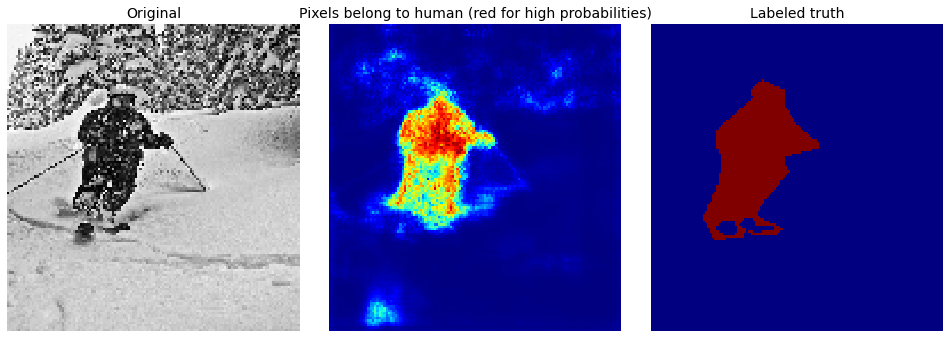

In [31]:
i_sample = 12

fig, AX = plt.subplots(1, 3, figsize=(13, (13 - 0.2) / 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);
